In [1]:
library(Signac)
library(Seurat)
library(EnsDb.Mmusculus.v79)
library(GenomeInfoDb)
library(ggplot2)
library(patchwork)
set.seed(1234)

Attaching SeuratObject

필요한 패키지를 로딩중입니다: ensembldb

필요한 패키지를 로딩중입니다: BiocGenerics


다음의 패키지를 부착합니다: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


필요한 패키지를 로딩중입니다: GenomicRanges

필요한 패키지를 로딩중입니다: stats4

필요한 패키지를 로딩중입니다: S4Vectors


다음의 패키지를 부착합니다: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


필요한 패키지를 로딩중입니다: IRanges

필요한 패키지를 로딩중입니다: GenomeInfoDb

필요한 패키지를 로딩중입니다: GenomicFeatures

필요한 패키지를 로딩중입니다: AnnotationDbi

필요한 패키지를 로딩중입니다: 

In [2]:
skin <- readRDS("./RDS/E13_PD4.combined.240114.rds")

In [3]:
skin

An object of class Seurat 
338904 features across 45406 samples within 1 assay 
Active assay: peaks (338904 features, 338904 variable features)
 2 dimensional reductions calculated: lsi, umap

In [4]:
library(reticulate)
library(sceasy)
#use_condaenv('signac_2', required = TRUE)
use_python("/data/User/revolvefire/miniforge3/envs/scvi_raw/bin/python", required = TRUE)

In [5]:
sc <- import("scanpy", convert = FALSE)
scvi <- import("scvi", convert = FALSE)

In [6]:
py_config()

python:         /data/User/revolvefire/miniforge3/envs/scvi_raw/bin/python
libpython:      /data/User/revolvefire/miniforge3/envs/scvi_raw/lib/libpython3.11.so
pythonhome:     /data/User/revolvefire/miniforge3/envs/scvi_raw:/data/User/revolvefire/miniforge3/envs/scvi_raw
version:        3.11.7 | packaged by conda-forge | (main, Dec 15 2023, 08:38:37) [GCC 12.3.0]
numpy:          /data/User/revolvefire/.local/lib/python3.11/site-packages/numpy
numpy_version:  1.26.2
scanpy:         /data/User/revolvefire/miniforge3/envs/scvi_raw/lib/python3.11/site-packages/scanpy

NOTE: Python version was forced by use_python() function

In [7]:
adata <- convertFormat(skin, from="seurat", to="anndata", main_layer="counts", assay="peaks", drop_single_values=FALSE)
print(adata) # Note generally in Python, dataset conventions are obs x var

AnnData object with n_obs × n_vars = 45406 × 338904
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'dataset', 'day', 'bulk'
    var: 'count', 'percentile'
    obsm: 'X_lsi', 'X_umap'


In [8]:
adata

AnnData object with n_obs × n_vars = 45406 × 338904
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'dataset', 'day', 'bulk'
    var: 'count', 'percentile'
    obsm: 'X_lsi', 'X_umap'

In [10]:
sc$pp$filter_genes(adata, min_cells=3000)

None

In [11]:
adata

AnnData object with n_obs × n_vars = 45406 × 39174
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'nonprimary', 'passed_filters', 'is__cell_barcode', 'excluded_reason', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'dataset', 'day', 'bulk'
    var: 'count', 'percentile', 'n_cells'
    obsm: 'X_lsi', 'X_umap'

In [12]:
scvi$model$PEAKVI$setup_anndata(adata, batch_key="day")

None

In [13]:
pvi <- scvi$model$PEAKVI(adata)

In [14]:
pvi$train(check_val_every_n_epoch=as.integer(5))

None

In [15]:
pvi$save("240124.pvi_fromr_2-10.model")

None

In [17]:
# get the latent represenation
latent = pvi$get_latent_representation()

# put it back in our original Seurat object
latent <- as.matrix(latent)
rownames(latent) = colnames(skin)
ndims <- ncol(latent)
skin[["peakvi"]] <- CreateDimReducObject(embeddings = latent, key = "peakvi_", assay = "peaks")

Warning message:
"No columnames present in cell embeddings, setting to 'peakvi_1:14'"


In [18]:
skin

An object of class Seurat 
338904 features across 45406 samples within 1 assay 
Active assay: peaks (338904 features, 338904 variable features)
 3 dimensional reductions calculated: lsi, umap, peakvi

In [19]:
DefaultAssay(skin) <- "peaks"

In [20]:
# Find clusters, then run UMAP, and visualize
skin <- FindNeighbors(skin, reduction = "peakvi", dims=1:ndims)
skin <- FindClusters(skin, resolution = 0.9, verbose=FALSE)

skin <- RunUMAP(skin, reduction = "peakvi", dims=1:ndims, verbose=FALSE)

Computing nearest neighbor graph

Computing SNN

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


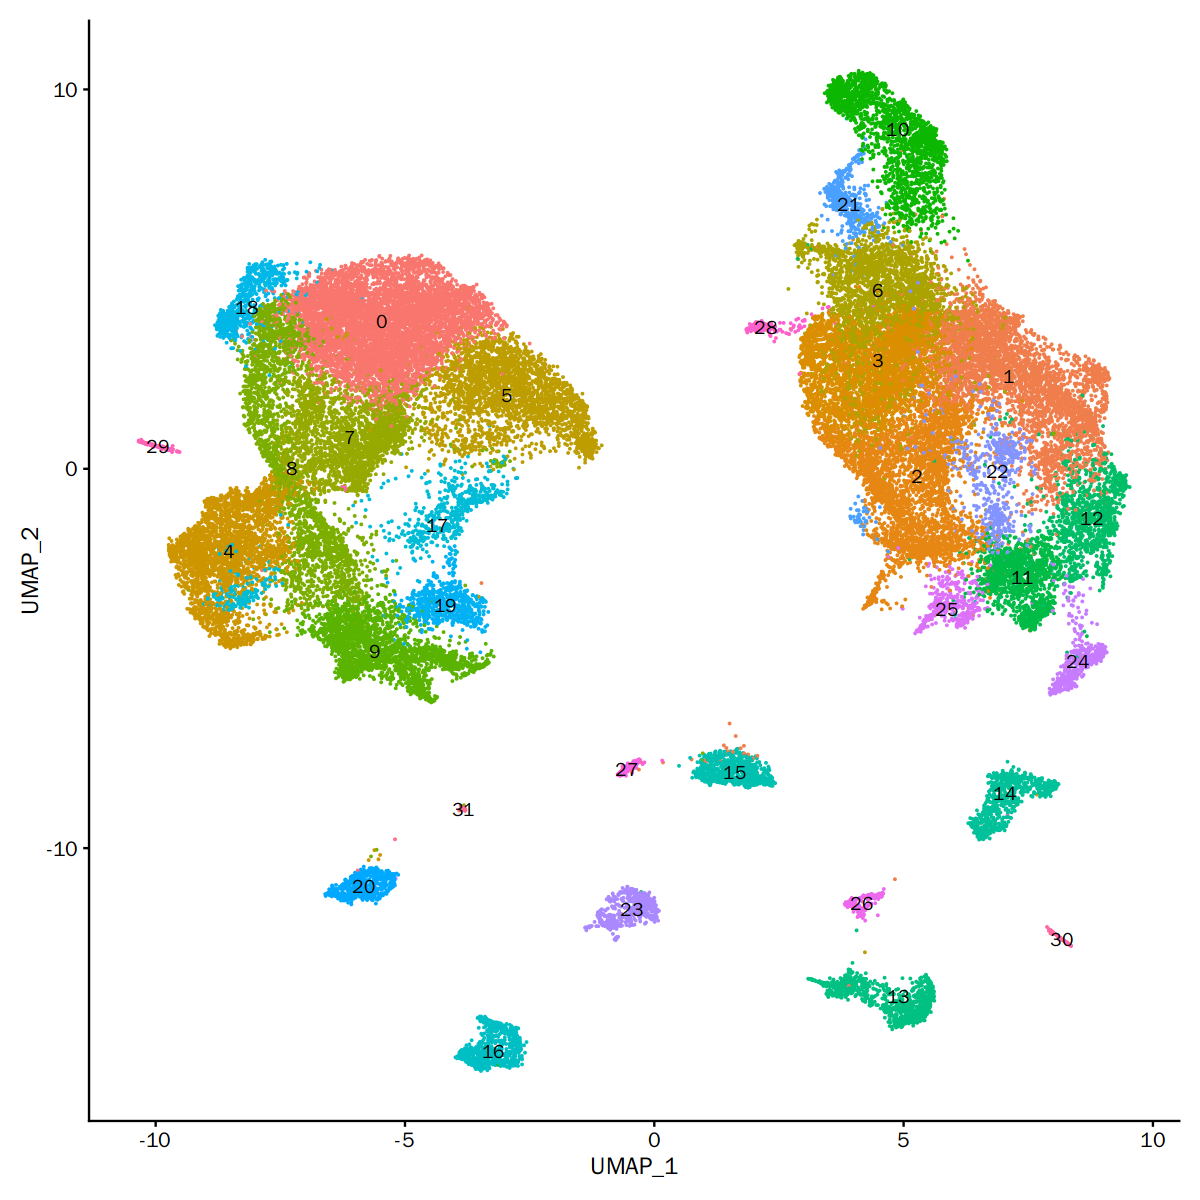

In [21]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = skin, label = TRUE) + NoLegend()

In [77]:
skin <- RunUMAP(skin, reduction = "peakvi", dims=1:ndims, verbose=FALSE, min.dist=0.3, spread=0.4)

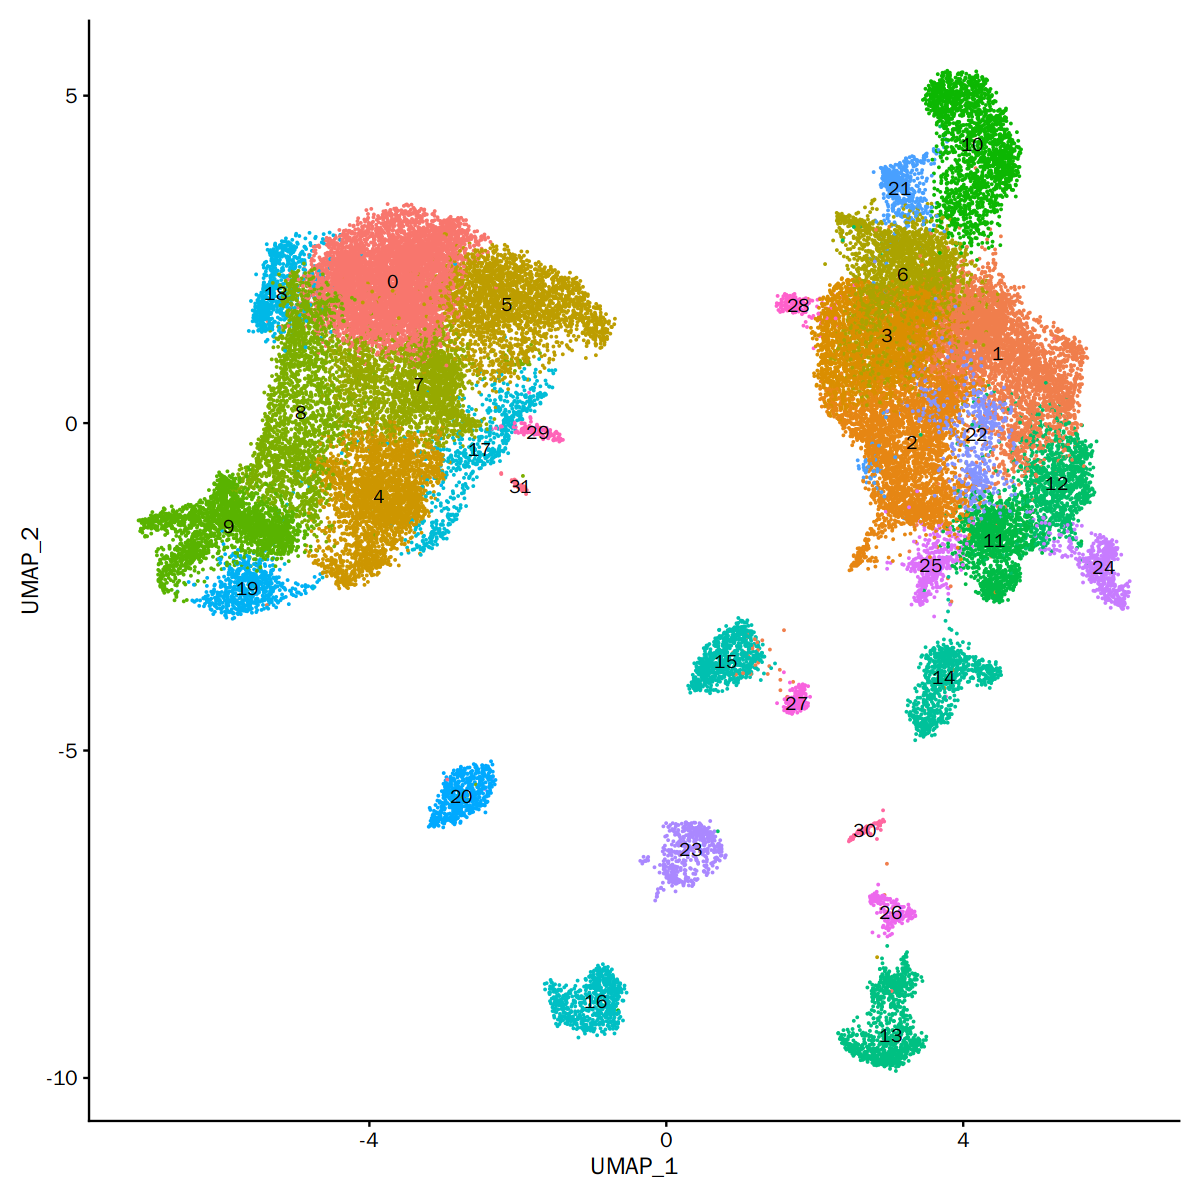

In [78]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(object = skin, label = TRUE) + NoLegend()

In [24]:
library(patchwork)

In [25]:
library(EnsDb.Mmusculus.v79)

In [26]:
#gene annotation necessary?

# extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Mmusculus.v79)

# change to UCSC style since the data was mapped to hg19
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "mm10"

# add the gene information to the object
Annotation(skin) <- annotations

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [27]:
# compute gene activities
gene.activities <- GeneActivity(skin)

Extracting gene coordinates

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [28]:
# add the gene activity matrix to the Seurat object as a new assay
skin[['RNA']] <- CreateAssayObject(counts = gene.activities)
skin <- NormalizeData(
  object = skin,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(skin$nCount_RNA)
)

In [29]:
skin_rna <- readRDS("/data/User/revolvefire/projects/1.ATAC_230519/231010_Signac_new/RDS/231206.adata_to_seurat.allgenes.rds")

In [30]:
skin_rna

An object of class Seurat 
18859 features across 67558 samples within 1 assay 
Active assay: RNA (18859 features, 0 variable features)

In [31]:
#skin_rna <- subset(skin_rna, subset = bulk.ident == "E16.5")
#skin_rna

In [32]:
skin_rna <- UpdateSeuratObject(skin_rna)
skin_rna <- FindVariableFeatures(
  object = skin_rna,
  nfeatures = 5000
)

Validating object structure

Updating object slots

Ensuring keys are in the proper structure

Ensuring feature names don't have underscores or pipes

Object representation is consistent with the most current Seurat version



In [33]:
skin_rna

An object of class Seurat 
18859 features across 67558 samples within 1 assay 
Active assay: RNA (18859 features, 5000 variable features)

In [35]:
DefaultAssay(skin) <- 'RNA'

In [36]:
transfer.anchors <- FindTransferAnchors(
  reference = skin_rna,
  query = skin,
  reduction = 'cca',
  dims = 1:30
)

predicted.labels <- TransferData(
  anchorset = transfer.anchors,
  refdata = skin_rna$leiden,
  weight.reduction = skin[['peakvi']],
  dims = 1:ndims
)

skin <- AddMetaData(object = skin, metadata = predicted.labels)

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 59662 anchors

Filtering anchors

	Retained 8517 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [88]:
options(repr.plot.width = 15, repr.plot.height = 10)

In [89]:
plot2 <- DimPlot(skin, group.by = 'predicted.id', label = TRUE, repel=TRUE) + ggtitle('scATAC-seq')

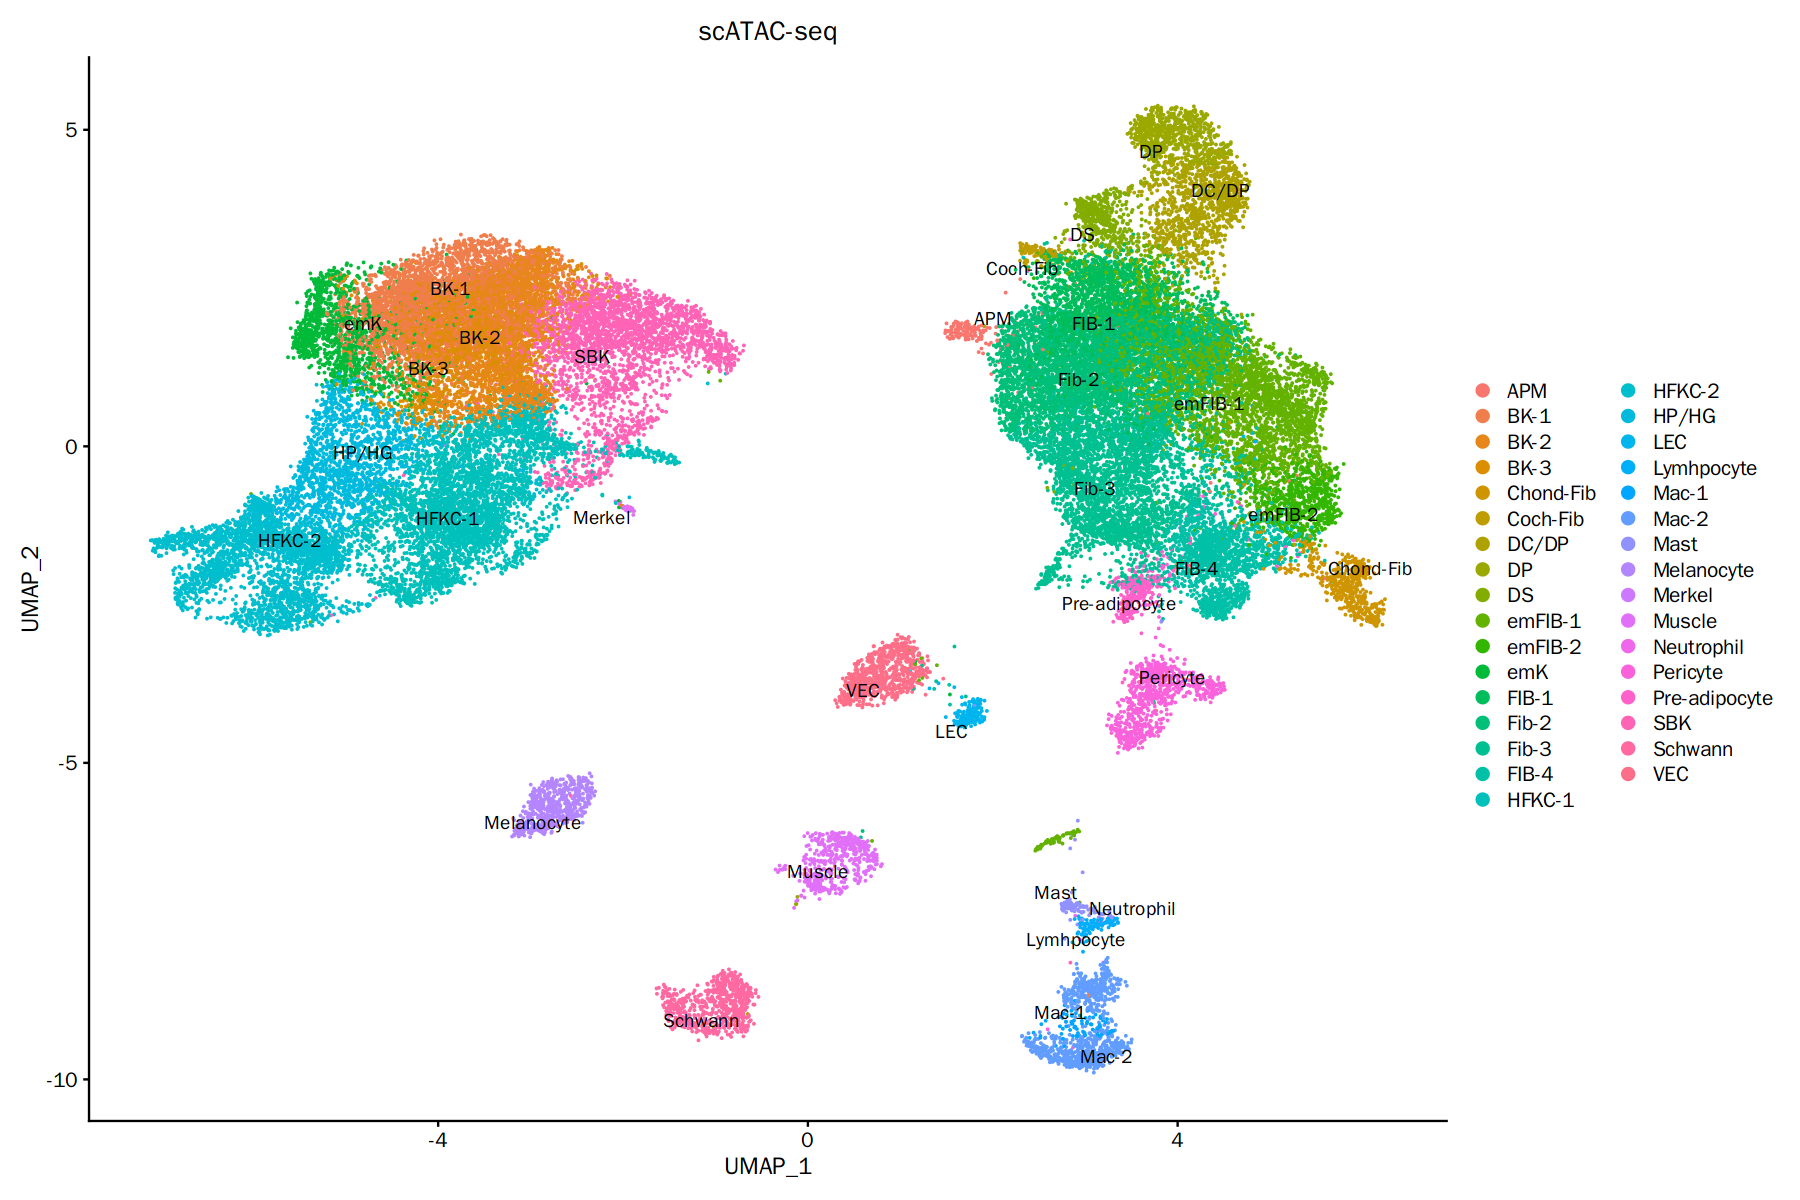

In [90]:
plot2